<a href="https://colab.research.google.com/github/Vengadore/Notebooks/blob/master/Roboflow_EfficientDet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For the most up to date version of this notebook, please copy from this link


---



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ZmbeTro4SqT7h_TfW63MLdqbrCUk_1br#scrollTo=KwDS9qqBbMQa)




# Overview

💡 Recommendation: Open this blog post on [how to train EfficientDet](https://towardsdatascience.com/training-efficientdet-object-detection-model-with-a-custom-dataset-25fb0f190555) to continue.

In this notebook we show an example of how to train EfficientDet using a pytorch implementation on a custom dataset that has been uploaded through RoboFlow. The example provides a flexible framework, so you can apply it to your own dataset with a custom number of classes and a different objective. We we tackle chess here. 

![Chess Example](https://i.imgur.com/nkjobw1.png)

### **Our Data and Roboflow**

Our dataset of 289 chess images (and 2894 annotations!) is hosted publicly on Roboflow [here](https://public.roboflow.ai/object-detection/chess-full). Roboflow also hosts many other public datasets and you can easily upload your own custom dataset for your use case, augment, and export in flexible formats. Our tutorial uses Coco Json, but you might have another format (say tfrecord). No problem! Upload your dataset and we will export it in the required format.

### **Model and Training**

For a deep dive on the EfficientDet model please see [the paper](https://arxiv.org/abs/1911.09070). For a shorter look, here is a great [blog post](https://towardsdatascience.com/efficientdet-scalable-and-efficient-object-detection-review-4472ffc34fd9)! 

We use a pytorch implementation of EfficientDet using the [image detection library](https://github.com/roboflow-ai/Monk_Object_Detection) from Tessellate-Imaging for object detection. Our implementation uses the base version of EfficientDet-d0.  We train from the EfficientNet base backbone, without using a pretrained checkpoint for the detector.

### **Inference**

We witness some fast inference on a few basic examples from our test set to see that our approach is heading in the right direction.

### **Export**

We export our model weights to google drive for future utilization.

### **Next Steps**

We will be exploring evaluation on custom RoboFlow datasets and objectives compared to yoloV3, including training time, inference time, model size, and performance. 

We will also explore comparing performance from the Coco pretrained checkpoint!

## **Stay in touch!**

If you run into any hurdles on your own data set or just want to share some cool results in your own domain, [reach out to us](roboflow.ai)! 

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)



# Setting up our envionment

In [76]:
#our fork of the Tessellate-Imaging image detection library
#!rm -rf Monk_Object_Detection
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git

fatal: destination path 'Monk_Object_Detection' already exists and is not an empty directory.


In [77]:
# For colab use the command below
# Set up library requirments
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

In [3]:
#fixed version of tqdm output for Colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#IGNORE restart runtime warning, it is indeed installed
#missing a few extra packages that we will need later! 
!pip install efficientnet_pytorch
!pip install tensorboardX

     \ 389kB 10.6MB/s
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47868 sha256=4b04c515a9b496a5723d0a71d8c762be9497566b24cb59ee8d556067d51de3a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-qo65966k/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.28.1 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement tqdm>=4.36.1, but you'll have tqdm 4.28.1 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=33835afa27b37478048e6214b7a34243aa88099d39969ef01cfb6aa478500ebf
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch
     |██████████████████

# Let's get some data! 

The best part about Roboflow is the efficient management of your datasets. [Upload you dataset](roboflow.ai) and you will recieve a fresh curl code to ouput it in whatever augmented and annotated format you need. 

In [4]:
#fresh curl courtesy of roboflow.ai, outputing our dataset in Coco Json format

##THIS CELL NEEDS CHANGED##

!curl -L "https://app.roboflow.com/ds/FxQaqQ18sL?key=ZyLG4t7zqg" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0   1023      0 --:--:-- --:--:-- --:--:--  1021
100  143M  100  143M    0     0  74.1M      0  0:00:01  0:00:01 --:--:--  236M
Archive:  roboflow.zip
 extracting: test/17221_right_jpeg.rf.54ab8d553d5ae4d72a6644cc5fbe406e.jpg  
 extracting: test/38513_left_jpeg.rf.1dac728ea9720ccb111926221e676210.jpg  
 extracting: test/6997_right_jpeg.rf.22ee08ede7ac5a48558bb443956893a5.jpg  
 extracting: test/29839_left_jpeg.rf.549f2e98d3b641c076070f4027c0706c.jpg  
 extracting: test/30255_right_jpeg.rf.073b108a42514d162592d07d4cea0ab6.jpg  
 extracting: test/17489_left_jpeg.rf.418ce34baec3ffc6316dfa646d1f9d6b.jpg  
 extracting: test/8292_left_jpeg.rf.2f2ecc7bade5ce16ff7b46102e615255.jpg  
 extracting: test/5825_left_jpeg.rf.445e7a5451c01bd521a0117fed4bca88.jpg  
 extracting: test/43997_left_jpeg.rf.1a8e2e3cf67a94a2

In [5]:
#let's take a look at our directory
#notice the data came down in train, valid, test, splits - this is pre set during the dataset upload process
%ls

Monk_Object_Detection/  sample_data/  train/
README.roboflow.txt     test/         valid/


In [6]:
#let's take a peak in train
#jpg images and some coco json annotations
%ls train

10017_left_jpeg.rf.385d1a43b274ed98c79ae27544bbf46d.jpg
10017_left_jpeg.rf.9ac77ce23fc46aeac0ab718552f75bf2.jpg
10017_left_jpeg.rf.9daf395677e8a670fa8e848e23fd61ab.jpg
10017_right_jpeg.rf.52678048f598fa9c80908c743a3a5a8f.jpg
10017_right_jpeg.rf.bbcb343252ccdb24f68215da6b7aeb6e.jpg
10047_right_jpeg.rf.9649042f30758624e2d8b41d7d3a8b70.jpg
10047_right_jpeg.rf.98dfa535349fa85395a5932370ca5047.jpg
10047_right_jpeg.rf.990765f051c472a43540db1ebf2dcbb9.jpg
10193_right_jpeg.rf.23142c147008c5366ea492b60647f7ed.jpg
10193_right_jpeg.rf.7512fd03b267a9fcb24e0dda3bb25ccf.jpg
10193_right_jpeg.rf.cc5081cfe21619aaa55bf02294555f73.jpg
10312_left_jpeg.rf.431cfe70dad461745210b43804c56a86.jpg
10312_left_jpeg.rf.89cd0e3c627b16892789ad1d56741930.jpg
10312_left_jpeg.rf.8ae6c5619b20b9531faa3ecaa7c22a16.jpg
10321_left_jpeg.rf.1e18e19def2762899d2bc775b8d2c0e7.jpg
10321_left_jpeg.rf.347a1e2e6157d3349d1fae7783768676.jpg
10321_left_jpeg.rf.679f6a7435c7310d066703a89aa6f126.jpg
10570_left_jpeg.rf.3282eb3f1a46535966e65

In [8]:
#let's take a peek at the annotations
#class categories, and bounding boxes are provided for our train set
#%pycat train/_annotations.coco.json

In [9]:
#in the next three cells, we move the data into a structure that the image detection library will be expecting
#but no file data manipulation is necessary
#images can also be segmented into class folders, but we combine all classes here
!mkdir APEC
!mkdir APEC/annotations
!mkdir APEC/Annotations
!mkdir APEC/Images

In [10]:
%cp train/_annotations.coco.json APEC/annotations/instances_Images.json

In [11]:
%cp train/*.jpg APEC/Images/

# Training

In this section we set up the efficientDet-d0 model from backbone and train to our custom case

In [12]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [13]:
from train_detector import Detector

In [14]:
gtf = Detector();

In [15]:
#directs the model towards file structure
root_dir = "./";
coco_dir = "APEC";
img_dir = "./";
set_dir = "Images";

In [16]:
#smells like some free compute from Colab, nice
gtf.Train_Dataset(root_dir, coco_dir, img_dir, set_dir, batch_size=8, image_size=512, use_gpu=True)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [17]:
gtf.Model();

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [18]:
gtf.Set_Hyperparams(lr=0.0001, val_interval=1, es_min_delta=0.0, es_patience=0)

In [19]:
%%time
gtf.Train(num_epochs=100, model_output_dir="trained/");

Monk_Object_Detection/4_efficientdet/lib/src/model.py:251: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if len(inputs) == 2:
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:84: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  image_shape = np.array(image_shape)
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:96: TracerWarning: torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this fu

KeyboardInterrupt: ignored

# Inference

In [20]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [21]:
from infer_detector import Infer

In [22]:
gtf = Infer();

In [23]:
#our trained model weights are in here in onxx format
gtf.Model(model_dir="trained/")

In [24]:
#extract class list from our annotations
import json
with open('train/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])

In [25]:
class_list

['APEC', 'NV']

In [74]:
%%time
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]
import random
img_path = "test/" + random.choice(test_images);
duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.5);

Done. (0.034s)
CPU times: user 242 ms, sys: 7.79 ms, total: 249 ms
Wall time: 247 ms


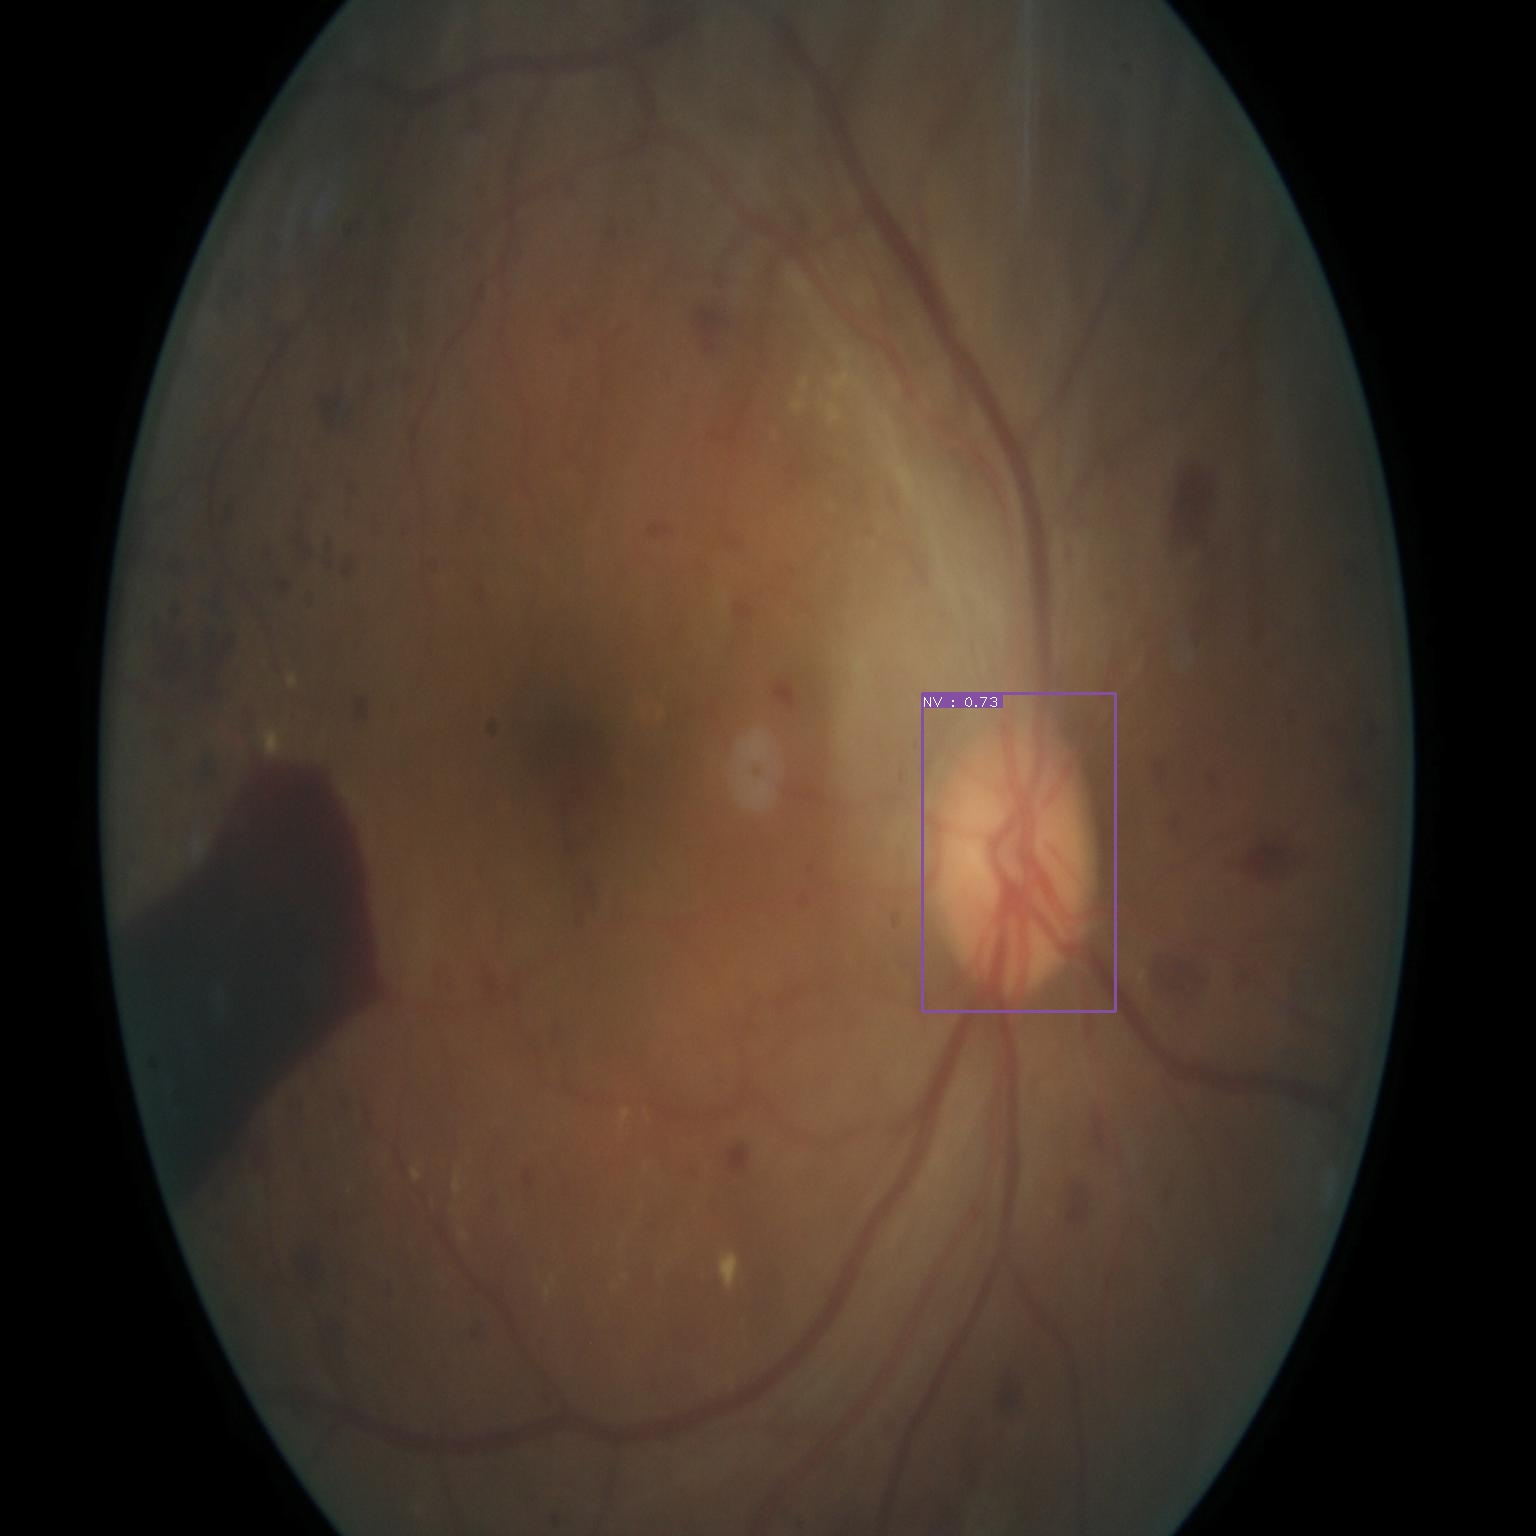

In [75]:
from IPython.display import Image
Image(filename='output.jpg',width=1200,height=1200) 

# Export Trained Weights

In [ ]:
#export trained model
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%mkdir trained_export
%cp ./trained/signatrix_efficientdet_coco.onnx ./trained_export/signatrix_efficientdet_coco_$(date +%F-%H:%M).onnx
%cp ./trained/signatrix_efficientdet_coco.pth ./trained_export/signatrix_efficientdet_coco_$(date +%F-%H:%M).pth
%mv ./trained_export/* /content/drive/My\ Drive/

# Reloading Trained Weights after Export

Imagine you have exported your trained model and would like to reaccess it later. This portion of the notebook picks up the trained model and starts at inference


In [ ]:
#export trained model
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#our fork of the Tessellate-Imaging image detection library
#!rm -rf Monk_Object_Detection
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git

In [ ]:
# For colab use the command below
# Set up library requirments
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

#fixed version of tqdm output for Colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#IGNORE restart runtime warning, it is indeed installed
#missing a few extra packages that we will need later! 
!pip install efficientnet_pytorch
!pip install tensorboardX

In [ ]:
#recover trained weights
!mkdir '/trained'
#note these are old weights that I didn't train for too long
!cp '/content/drive/My Drive/signatrix_efficientdet_coco_2020-04-10-15:18.onnx' '/trained/signatrix_efficientdet_coco.onnx'
!cp '/content/drive/My Drive/signatrix_efficientdet_coco_2020-04-10-15:18.pth' '/trained/signatrix_efficientdet_coco.pth'

In [ ]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [ ]:
from infer_detector import Infer
gtf = Infer();

In [ ]:
#our trained model weights are in here in onxx format
gtf.Model(model_dir="/trained")

In [ ]:
#download some test data
!curl -L [YOUR LINK HERE] | jar -x

In [ ]:
!ls test

In [ ]:
#extract class list from our annotations
#in your application you will probably already have this saved
import json
with open('train/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])

In [ ]:
class_list

In [ ]:
%%time
#bang!
img_path = "test/2f6fb003bb89cd401322a535acb42f65_jpg.rf.49b342a7b1f6de3f0e328beaf094a945.jpg";
duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.2);

In [ ]:
from IPython.display import Image
Image(filename='output.jpg') 